# **Neural network**

In [46]:
import pandas as pd

In [47]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [48]:
print(f"Number of data points in the training set: {train_data.shape[0]}")
print(f"Number of data points in the test set: {test_data.shape[0]}")

Number of data points in the training set: 373598
Number of data points in the test set: 35406


Drop unused features

In [49]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [50]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

## Preprocessing Pipeline

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 

Given that this model supports only numerical features, in the pipeline we consider only numerical transformations

In [52]:
numeric_features = train_data.columns
numeric_transformer = StandardScaler()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

## NN Classifier

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

Given the high amount of parameters and combinations of them, we decided to adopt a randomized search approach over the parameter space, given the high dimensionality of the latter 

NOTE: resempling is added in the preprocessing pipeline in order to be applied olny on training data.

In [54]:
clf = MLPClassifier(random_state=1)
#sampler = SMOTETomek(random_state=1)
sampler = RandomOverSampler(random_state=1)
#sampler = RandomUnderSampler(random_state=1)

# Pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),  
        ("sampler", sampler),
        ("clf", clf)
    ]
)

parameters = {
    'clf__hidden_layer_sizes': [(50, 50), (100, 50), (150,75), (50, 30, 10), (70, 35, 12), (150, 75, 25), (30, 20, 10, 5), (50, 30, 20, 10)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__learning_rate_init': [0.001, 0.01, 0.1],
    'clf__batch_size': ['auto', 16, 32, 64, 128],
    'clf__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__max_iter': [100, 200, 500]  
}


scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

rscv = RandomizedSearchCV(
    model,
    param_distributions=parameters,
    scoring=scoring,  
    n_iter=50,  
    cv=5,  
    verbose=1,  
    n_jobs=-1,  
    random_state=10, 
    refit="f1", 
    return_train_score=True
)

rscv.fit(train_data, train_labels.values.ravel())


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object'))])),
                                             ('sampler',
                                              RandomOverSampler(random_state=1)),
                                             ('clf',
                                              MLPClassifier(random_s...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Training scores:

In [55]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_model = rscv.best_estimator_
best_index = rscv.best_index_

#extract and print matrics
mean_train_scores = {metric: cv_results[f'mean_train_{metric}'][best_index] for metric in scoring.keys()}
std_train_scores = {metric: cv_results[f'std_train_{metric}'][best_index] for metric in scoring.keys()}

print("Training results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_train_scores[metric]:.4f}, Std: {std_train_scores[metric]:.4f}")


Training results of the best model:
Sensitivity - Mean: 0.6899, Std: 0.0107
Specificity - Mean: 0.7319, Std: 0.0094
Accuracy - Mean: 0.7263, Std: 0.0067
Precision - Mean: 0.2828, Std: 0.0039
Recall - Mean: 0.6899, Std: 0.0107
Roc_auc - Mean: 0.7824, Std: 0.0002
F1 - Mean: 0.4011, Std: 0.0022


### Validation scores:

In [56]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_model = rscv.best_estimator_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.6826, Std: 0.0095
Specificity - Mean: 0.7308, Std: 0.0094
Accuracy - Mean: 0.7244, Std: 0.0069
Precision - Mean: 0.2798, Std: 0.0043
Recall - Mean: 0.6826, Std: 0.0095
Roc_auc - Mean: 0.7765, Std: 0.0009
F1 - Mean: 0.3968, Std: 0.0029


### Test scores:

Accuracy: 0.684
Recall: 0.74
Precision: 0.281
Sensitivity: 0.74
Specificity: 0.675
F1 Score: 0.407
ROC AUC Score: 0.707


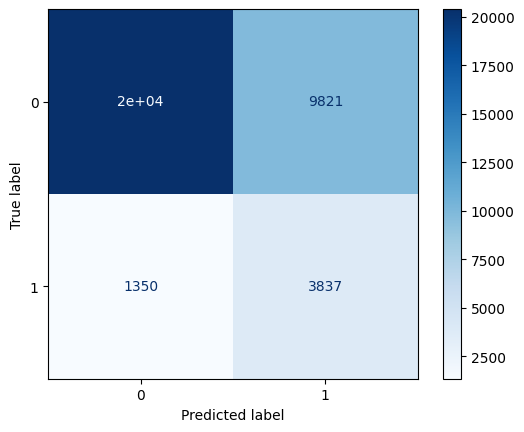

In [57]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [58]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     30219
           1       0.28      0.74      0.41      5187

    accuracy                           0.68     35406
   macro avg       0.61      0.71      0.60     35406
weighted avg       0.84      0.68      0.73     35406



## Save Results

In [59]:
import sys
sys.path.append('..')
from utils import save_results

resampling = "smotetomek"   # "no", "under", "over", "smotetomek"
save_results('nn', resampling, mean_train_scores, std_train_scores, mean_test_scores, std_test_scores, accuracy, recall, precision, sensitivity_score, specificity_score, f1, roc_auc, report)

## Model Save

In [60]:
"""import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/nn.pkl')"""

"import joblib\nimport os\n\n# Create the directory if it doesn't exist\nos.makedirs('best_models', exist_ok=True)\n# Save the best model\njoblib.dump(best_model, 'best_models/nn.pkl')"

## Results
All resampling strategies boosted performance over the baseline (no resampling). Oversampling and SMOTETomek provided the best F1 Score and ROC AUC, indicating a preferable balance between precision and recall as well as improved class separation.